### 1.Set up and load Data

1.1 Install Dependencies and Setup

In [176]:
# %pip install tensorflow tenserflow-gpu opencv-python matplotlib

In [177]:
# %pip list

In [178]:
import tensorflow as tf
import os

In [179]:
print("TF version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device:", tf.test.gpu_device_name())


TF version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device: /device:GPU:0


In [180]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [181]:
# Avoid OOM error by setting GPU memory consumption growth
tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove dodgy images

In [182]:
import cv2
import imghdr

In [183]:
data_dir = 'data'

In [184]:
os.listdir(data_dir)

['anime people', 'happy people', 'sad people']

In [185]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [186]:
for image_class in os.listdir(data_dir): # list image class
    for image in os.listdir(os.path.join(data_dir, image_class)): # list image in each class
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image is not  in ext list  {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_exts))
            

Image is not  in ext list  data\anime people\125359467.jpeg
Image is not  in ext list  data\anime people\5351c58d-cfa2-4bf8-9a44-8488d679bae3.jpg
Image is not  in ext list  data\anime people\6445fe56-0902-4daa-8ae5-d39dc2374680.jpg
Image is not  in ext list  data\anime people\7-แอปสร้างภาพอนิเมะ-2566-2023.png
Image is not  in ext list  data\anime people\8d7fdb6c94fee0a80401059dee98bc75.jpeg
Image is not  in ext list  data\anime people\a117ef9d-9f3d-48c2-a78b-426bbdce1109.jpg
Image is not  in ext list  data\anime people\fx8lgiuu2s_animecoversquare.jpg
Image is not  in ext list  data\anime people\Kimetsu-no-Yaiba-2021-anime.jpg


1.3 Load Data

In [187]:
import numpy as np
from matplotlib import pyplot as plt

In [188]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 469 files belonging to 3 classes.


In [189]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [190]:
data_iterator = data.as_numpy_iterator()

In [191]:
# Get another batch from the iterator
batch = data_iterator.next()

In [192]:
# Imaages representd as  numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [193]:
# Class 1 = sad 
# Class 0 = happy
batch[1]

array([2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 0, 1, 0, 2, 0, 0, 1, 0, 1])

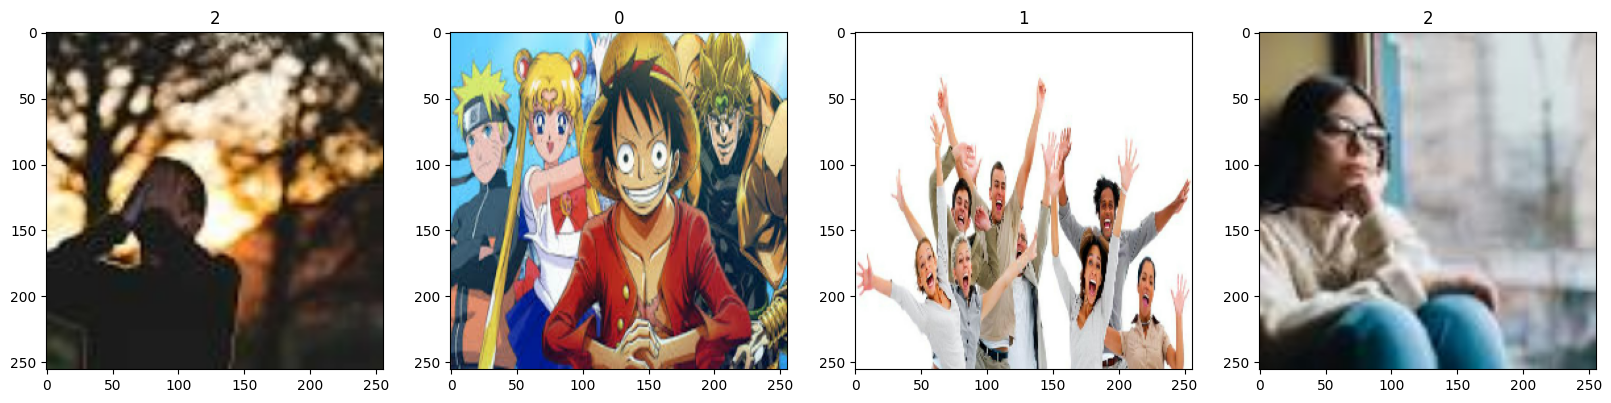

In [194]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

1.4 Scale Data

In [195]:
scaled = batch[0] /255

In [196]:
scaled.max()

1.0

### 2.Preprocess data

2.1 Scale Data

In [197]:
data = data.map(lambda x,y: (x/255,y))

In [198]:
scaled_iterator = data.as_numpy_iterator()

In [199]:
batch = scaled_iterator.next()

In [200]:
batch[0].min()

0.0

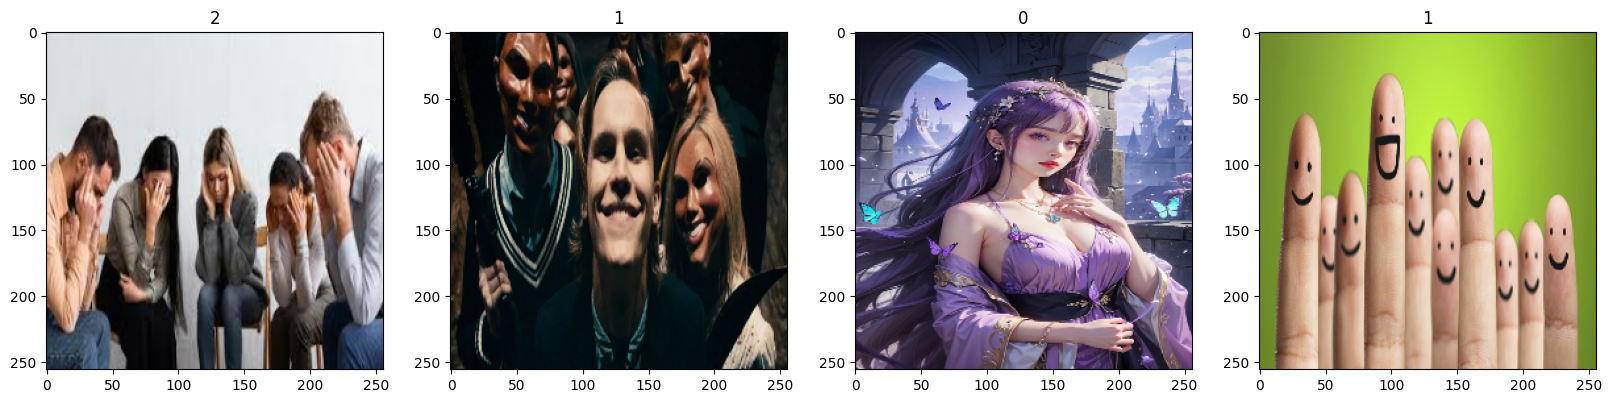

In [201]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 split data

In [202]:
len(data)

15

In [203]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [204]:
train_size+val_size+test_size

15

In [205]:
train = data.take(train_size) # ใช้ data กี่ตัวในการtrain
val = data.skip(train_size).take(val_size) # skip data ที่เอาไป train แล้ว
test = data.skip(train_size+val_size).take(test_size)

In [263]:
len(test)

2

### 3.Deep Model

3.1 Build Deep Learning Model

In [207]:
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [208]:
model = Sequential()

activation='relu'
✅ ข้อดี:
- ทำงานเร็ว คำนวณง่าย

- ลดปัญหา vanishing gradient ที่เจอบ่อยกับ Sigmoid

- ช่วยให้ deep network ฝึกได้ดีขึ้น

- เหมาะกับ convolutional layers อย่างมาก (เช่นในตัวอย่างของคุณ)

⚠️ ข้อเสีย:
- มีโอกาสเกิด “dying ReLU” (ค่าทั้งหมดกลายเป็น 0 ถ้า weight ทำให้ input ติดลบตลอด)

activation='sigmoid'
✅ ข้อดี:
- เหมาะกับปัญหา binary classification (เช่น output layer)

- ให้ความน่าจะเป็นเข้าใจง่าย (0 = ไม่แน่ใจ, 1 = มั่นใจ)

⚠️ ข้อเสีย:
- มีปัญหา vanishing gradient (gradient เล็กมากเมื่อค่าเข้าใกล้ 0 หรือ 1)

- ค่าที่ออกมาจะไม่เป็น 0-mean → ทำให้การเรียนรู้ช้าลง

- ไม่ค่อยนิยมใช้ใน hidden layers ของ deep network แล้ว

In [209]:
# add convolutiuon 16 filter, 3*3 pixels, stride 1 pixel each time
# relu activation เป็นกราฟรูปแบบหนึ่งจะไม่ติดลบ ต่างกับ Sigmoid

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [210]:
# สำหรับ 2 ชุดข้อมูล
# model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# สำหรับ หลายชุดข้อมูล
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [211]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

3.2 Train

In [212]:
logdir = 'logs'

In [213]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [214]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 5s 410ms/step - loss: 1.5009 - accuracy: 0.3299 - val_loss: 1.0249 - val_accuracy: 0.4531
Epoch 2/20
9/9 [==============================] - 5s 424ms/step - loss: 1.0091 - accuracy: 0.5104 - val_loss: 0.9077 - val_accuracy: 0.4531
Epoch 3/20
9/9 [==============================] - 4s 405ms/step - loss: 0.8947 - accuracy: 0.5833 - val_loss: 0.8206 - val_accuracy: 0.6562
Epoch 4/20
9/9 [==============================] - 4s 403ms/step - loss: 0.8061 - accuracy: 0.6562 - val_loss: 0.7232 - val_accuracy: 0.7734
Epoch 5/20
9/9 [==============================] - 4s 409ms/step - loss: 0.6631 - accuracy: 0.7361 - val_loss: 0.6290 - val_accuracy: 0.7891
Epoch 6/20
9/9 [==============================] - 4s 394ms/step - loss: 0.5847 - accuracy: 0.7917 - val_loss: 0.5057 - val_accuracy: 0.8672
Epoch 7/20
9/9 [==============================] - 4s 398ms/step - loss: 0.4703 - accuracy: 0.8646 - val_loss: 0.3875 - val_accuracy: 0.8516
Epoch 8/20
9/9 [====

3.3 Plot performance

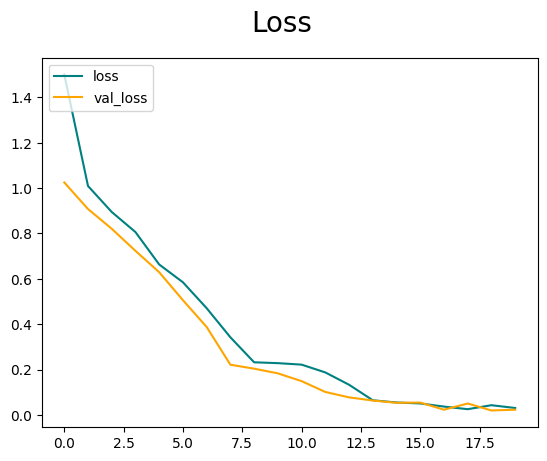

In [215]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

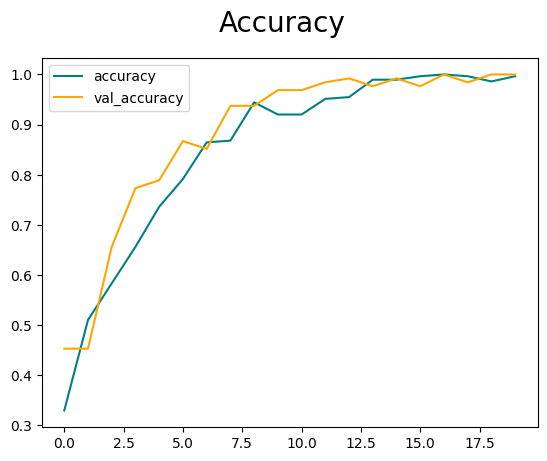

In [216]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4. Evaluate Performance

4.1 Evaluate

In [217]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [218]:
# สำหรับ 2 ชุดข้อมูล
# pre = Precision()
# re = Recall()
# acc = BinaryAccuracy()

acc = SparseCategoricalAccuracy()
pre = Precision()
re = Recall()

In [219]:
# สำหรับ 2 ชุดข้อมูล
# for batch in test.as_numpy_iterator(): 
#     X, y = batch
#     yhat = model.predict(X)
#     pre.update_state(y, yhat)
#     re.update_state(y, yhat)
#     acc.update_state(y, yhat)

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # หาค่าทำนายเป็นเลข class
    yhat_class = tf.argmax(yhat, axis=1)
    acc.update_state(y, yhat)
    pre.update_state(y, yhat_class)
    re.update_state(y, yhat_class)

1/1 [==============================] - 0s 425ms/step


In [220]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9811321, shape=(), dtype=float32)


4.2 Test

In [221]:
import cv2

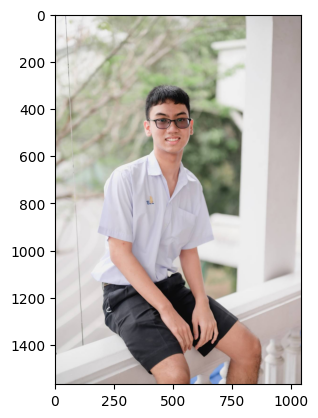

In [257]:
img = cv2.imread('happy_test3.jpg')
# img = cv2.imread('anime_test.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

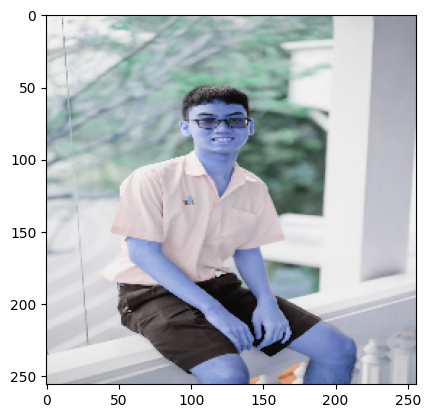

In [258]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [259]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 23ms/step


In [260]:
yhat

array([[0.23435825, 0.25217894, 0.51346284]], dtype=float32)

In [261]:
predicted_class = tf.argmax(yhat, axis=1).numpy()[0]
print(f"Predicted class index: {predicted_class}")


Predicted class index: 2


In [262]:
class_names = ['Anime', 'Happy', 'Sad']
print(f"Predicted class name: {class_names[predicted_class]}")

Predicted class name: Sad


### 5. Save Model

In [228]:
from tensorflow.keras.models import load_model

In [229]:
model.save(os.path.join('models', 'happy_sad_model.h5'))

In [230]:
new_model = load_model(os.path.join('models', 'happy_sad_model.h5'))

In [231]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 65ms/step


In [232]:
yhatnew

array([[0.9467341 , 0.03989192, 0.01337405]], dtype=float32)